In [1]:
import numpy as np
import matplotlib.pyplot as plt

#=========================================
# プロットのスタイル設定
#=========================================

# フォントの設定
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['font.size'] = 12

# 目盛りの設定
plt.rcParams['xtick.direction'] = 'in'  # x軸の目盛りを内向きに
plt.rcParams['ytick.direction'] = 'in'  # y軸の目盛りを内向きに
plt.rcParams['xtick.major.width'] = 1.0  # x軸主目盛りの線幅
plt.rcParams['ytick.major.width'] = 1.0  # y軸主目盛りの線幅

# グラフの枠線と余白の設定
plt.rcParams['axes.linewidth'] = 1.0  # グラフ枠の線幅
plt.rcParams['axes.xmargin'] = 0.01   # x軸の余白
plt.rcParams['axes.ymargin'] = 0.01   # y軸の余白

# 凡例の設定
plt.rcParams["legend.fancybox"] = False     # 凡例を角丸にしない
plt.rcParams["legend.framealpha"] = 1       # 凡例の背景を不透明に
plt.rcParams["legend.edgecolor"] = 'black'  # 凡例の枠線の色

# 数式フォントの設定
plt.rcParams["mathtext.fontset"] = "stix"

#=========================================
# プロット用のスタイルリスト
#=========================================
# 線のスタイル
line_styles_list = ['-', '--', '-.', ':']

# マーカーのスタイル
makers_list = ['o', 's', '^', 'D', 'v', '<', '>', '1', '2', '3']

# 色のリスト
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
              'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

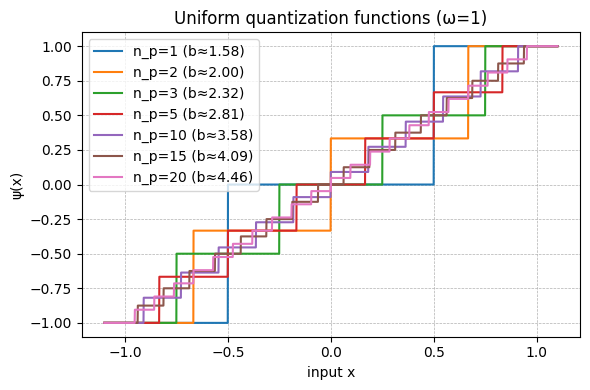

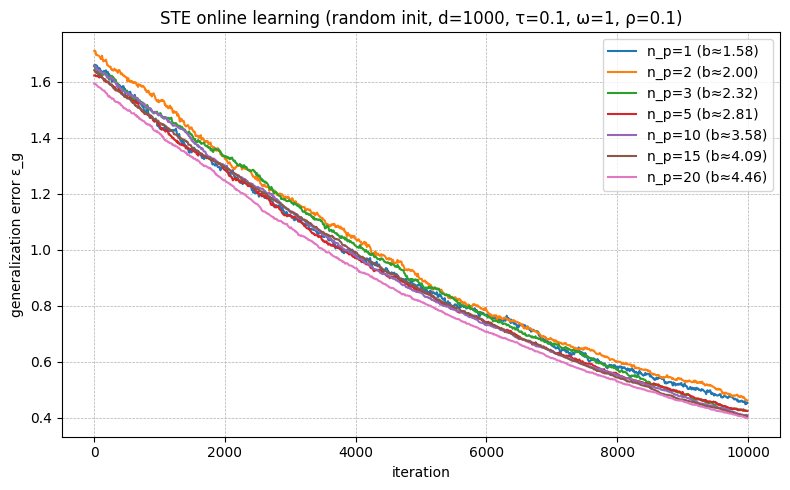

In [ ]:

# ===== updated full code with random initialization =====
def quantize(vec: np.ndarray, omega: float, n_p: int) -> np.ndarray:
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    indices = np.round((clipped + omega) / step)
    return -omega + indices * step

def order_params_error(w_quant: np.ndarray, w0: np.ndarray, rho: float) -> float:
    d = w0.size
    m0 = 1.0  # (1/d)||w0||^2 = 1  (w0 = 1-vector)
    m_psi = (w_quant @ w0) / d
    q_psi = (w_quant @ w_quant) / d
    return m0 - 2 * m_psi + q_psi + rho

def run_experiment(
    d: int,
    tau: float,
    omega: float,
    rho: float,
    n_p_list: list,
    T: int = 10_000,
    record_every: int = 10,
    seed: int = 0,
):
    rng = np.random.default_rng(seed)
    w0_teacher = np.ones(d)
    results = {}
    for n_p in n_p_list:
        # --- random Gaussian initial weights ---
        w = rng.standard_normal(d)
        eps_hist, steps_hist = [], []
        for t in range(T):
            x = rng.standard_normal(d)
            noise = rng.standard_normal() * np.sqrt(rho)
            y = (w0_teacher @ x) / np.sqrt(d) + noise

            w_quant = quantize(w, omega, n_p)
            y_hat = (w_quant @ x) / np.sqrt(d)

            grad = - (y - y_hat) * x / np.sqrt(d)
            w -= tau * grad

            if t % record_every == 0:
                eps_hist.append(order_params_error(w_quant, w0_teacher, rho))
                steps_hist.append(t)

        results[n_p] = (np.array(steps_hist), np.array(eps_hist))
    return results

def plot_quant_funcs(omega: float, n_p_list: list):
    x_plot = np.linspace(-omega * 1.1, omega * 1.1, 2001)
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, n_p in enumerate(n_p_list):
        ax.plot(x_plot, quantize(x_plot, omega, n_p),
                color=colors[idx % len(colors)],
                label=f"n_p={n_p} (b≈{np.log2(n_p+2):.2f})")
    ax.set_xlabel("input x")
    ax.set_ylabel("ψ(x)")
    ax.set_title(f"Uniform quantization functions (ω={omega})")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_epsilon(results: dict, omega: float, d: int, tau: float, rho: float):
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, (n_p, (steps, eps)) in enumerate(results.items()):
        ax.plot(steps, eps,
                color=colors[idx % len(colors)],
                label=f"n_p={n_p} (b≈{np.log2(n_p+2):.2f})")
    ax.set_xlabel("iteration")
    ax.set_ylabel("generalization error ε_g")
    # ax.set_yscale("log")
    ax.set_title(f"STE online learning (random init, d={d}, τ={tau}, ω={omega}, ρ={rho})")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ----- run experiment with ρ=0.001 -----
d = 1000
tau = 0.1
omega = 1
rho = 0.1
n_p_list = [1, 2, 3, 5, 10, 15, 20]
T = 10000
record_every = 10

plot_quant_funcs(omega, n_p_list)

results_random_init = run_experiment(
    d=d,
    tau=tau,
    omega=omega,
    rho=rho,
    n_p_list=n_p_list,
    T=T,
    record_every=record_every,
    seed=123
)

plot_epsilon(results_random_init, omega, d, tau, rho)


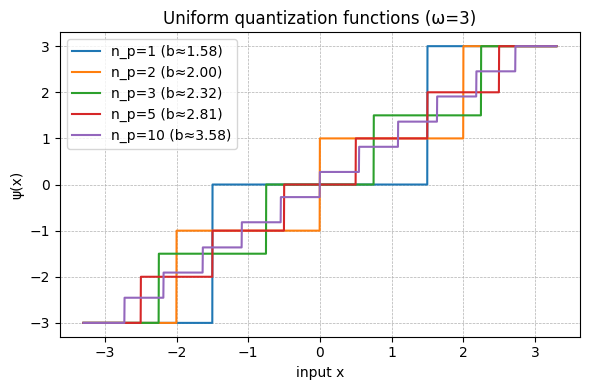

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# helper functions
# -------------------------------------------------
def quantize(vec, omega, n_p):
    """Uniform symmetric quantization with clipping to [-ω, ω]"""
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step


def run_one(d, tau, omega, rho, n_p, T, record_every, rng, quantized=True):
    """Run a single online SGD (with or without STE) and return order‑parameter traces."""
    w0_teacher = np.ones(d)
    w = rng.standard_normal(d)

    steps, eps, m_hist, q_hist = [], [], [], []

    for t in range(T):
        x = rng.standard_normal(d)
        y = (w0_teacher @ x) / np.sqrt(d) + rng.standard_normal() * np.sqrt(rho)

        if quantized:
            w_eff = quantize(w, omega, n_p)
        else:
            w_eff = w                        # no quantization

        y_hat = (w_eff @ x) / np.sqrt(d)
        grad = - (y - y_hat) * x / np.sqrt(d)  # STE gradient coincides with true for no‑quant
        w -= tau * grad

        if t % record_every == 0:
            m = (w_eff @ w0_teacher) / d
            q = (w_eff @ w_eff) / d
            err = 1.0 - 2 * m + q + rho      # ε_g  (m0 = 1 for teacher of 1's)

            steps.append(t)
            eps.append(err)
            m_hist.append(m)
            q_hist.append(q)

    return np.array(steps), np.array(eps), np.array(m_hist), np.array(q_hist)


def run_multi_seeds(d, tau, omega, rho, n_p_list, seeds, T=10_000, record_every=10):
    """Run many seeds; return dict[n_p] = {'steps', 'mean', 'std', ...}"""
    results = {}

    for n_p in n_p_list:
        eps_all, m_all, q_all = [], [], []

        for seed in seeds:
            rng = np.random.default_rng(seed)
            steps, eps, m_hist, q_hist = run_one(
                d, tau, omega, rho, n_p, T, record_every, rng, quantized=True
            )
            eps_all.append(eps)
            m_all.append(m_hist)
            q_all.append(q_hist)

        eps_all = np.stack(eps_all)
        m_all = np.stack(m_all)
        q_all = np.stack(q_all)

        results[n_p] = {
            'steps': steps,
            'eps_mean': eps_all.mean(axis=0),
            'eps_std':  eps_all.std(axis=0),
            'm_mean':   m_all.mean(axis=0),
            'm_std':    m_all.std(axis=0),
            'q_mean':   q_all.mean(axis=0),
            'q_std':    q_all.std(axis=0),
        }
    return results


def run_baseline_seeds(d, tau, rho, seeds, T=10_000, record_every=10):
    """No quantization baseline"""
    eps_all, m_all, q_all = [], [], []

    for seed in seeds:
        rng = np.random.default_rng(seed)
        steps, eps, m_hist, q_hist = run_one(
            d, tau, omega=0, rho=rho, n_p=0, T=T,
            record_every=record_every, rng=rng, quantized=False
        )
        eps_all.append(eps)
        m_all.append(m_hist)
        q_all.append(q_hist)

    eps_all = np.stack(eps_all)
    m_all = np.stack(m_all)
    q_all = np.stack(q_all)

    return {
        'steps': steps,
        'eps_mean': eps_all.mean(axis=0),
        'eps_std':  eps_all.std(axis=0),
        'm_mean':   m_all.mean(axis=0),
        'm_std':    m_all.std(axis=0),
        'q_mean':   q_all.mean(axis=0),
        'q_std':    q_all.std(axis=0),
    }

# -------------------------------------------------
# experiment parameters
# -------------------------------------------------
d = 1000
tau = 0.1
omega = 3
rho = 0.5
n_p_list = [1, 2, 3, 5, 10]
T = 40000
record_every = 10
seeds = [0, 1, 2, 3, 4]     # five different initializations


plot_quant_funcs(omega, n_p_list)

# -------------------------------------------------
# run experiments
# -------------------------------------------------
quant_results = run_multi_seeds(d, tau, omega, rho, n_p_list, seeds, T, record_every)
baseline = run_baseline_seeds(d, tau, rho, seeds, T, record_every)

# -------------------------------------------------
# plotting
# -------------------------------------------------
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# --- ε_g ---
ax = axes[0]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['eps_mean'], color=colors[idx % len(colors)],
            label=fr"$n_p=${n_p}")
    ax.fill_between(r['steps'],
                    r['eps_mean'] - r['eps_std'],
                    r['eps_mean'] + r['eps_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
# baseline
ax.plot(baseline['steps'], baseline['eps_mean'], color='black', linestyle='--', label='Baseline')
ax.fill_between(baseline['steps'],
                baseline['eps_mean'] - baseline['eps_std'],
                baseline['eps_mean'] + baseline['eps_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("ε_g")
# ax.set_yscale("log")
ax.set_title("Generalization error")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(ncol=3)

# --- m_ψ ---
ax = axes[1]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['m_mean'], color=colors[idx % len(colors)])
    ax.fill_between(r['steps'],
                    r['m_mean'] - r['m_std'],
                    r['m_mean'] + r['m_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
ax.plot(baseline['steps'], baseline['m_mean'], color='black', linestyle='--')
ax.fill_between(baseline['steps'],
                baseline['m_mean'] - baseline['m_std'],
                baseline['m_mean'] + baseline['m_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("m_ψ (or m)")
ax.set_title("Overlap with teacher")
ax.grid(True, linestyle='--', linewidth=0.5)

# --- q_ψ ---
ax = axes[2]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['q_mean'], color=colors[idx % len(colors)])
    ax.fill_between(r['steps'],
                    r['q_mean'] - r['q_std'],
                    r['q_mean'] + r['q_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
ax.plot(baseline['steps'], baseline['q_mean'], color='black', linestyle='--')
ax.fill_between(baseline['steps'],
                baseline['q_mean'] - baseline['q_std'],
                baseline['q_mean'] + baseline['q_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("q_ψ (or q)")
ax.set_xlabel("iteration")
ax.set_title("Self‑overlap of weights")
ax.grid(True, linestyle='--', linewidth=0.5)

plt.suptitle(f"Quantized vs Unquantized Online SGD  (d={d}, τ={tau}, ω={omega}, ρ={rho})",
            fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 等方性の仮定の数値検証

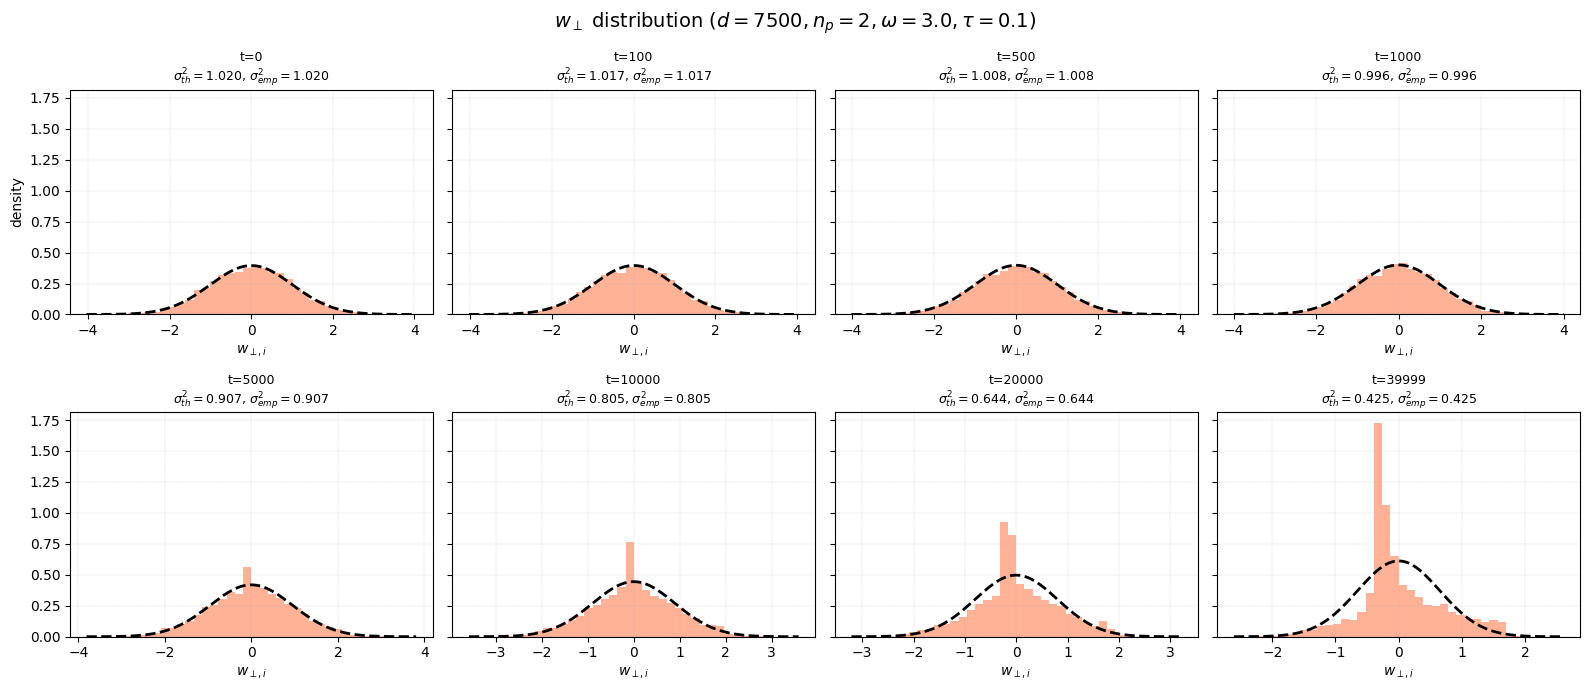

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
d = 7500
tau = 0.1
omega = 3.0
rho = 0.1
n_p = 2
T = 40000
check_steps = [0, 100, 500, 1000, 5000, 10000, 20000, 39999]

def quantize(vec, omega, n_p):
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step

# simulate
rng = np.random.default_rng(2026)
w0 = np.ones(d)
w = rng.standard_normal(d)
snapshots = {}

for t in range(T + 1):
    if t in check_steps:
        snapshots[t] = w.copy()
    if t == T:
        break
    x = rng.standard_normal(d)
    noise = rng.standard_normal() * np.sqrt(rho)
    y = (w0 @ x) / np.sqrt(d) + noise
    wq = quantize(w, omega, n_p)
    y_hat = (wq @ x) / np.sqrt(d)
    grad = -(y - y_hat) * x / np.sqrt(d)
    w -= tau * grad

# plotting
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows), sharey=True)
axes = axes.flatten()

for ax, t in zip(axes, check_steps):
    w_t = snapshots[t]
    m = (w_t @ w0) / d
    q = (w_t @ w_t) / d
    sigma2_th = q - m**2
    w_perp = w_t - m * w0
    sigma2_emp = w_perp.var()
    
    bins = np.linspace(-4*np.sqrt(sigma2_th), 4*np.sqrt(sigma2_th), 41)
    ax.hist(w_perp, bins=bins, density=True, alpha=0.6, color='coral')
    x_plot = np.linspace(bins[0], bins[-1], 400)
    ax.plot(x_plot, norm.pdf(x_plot, 0, np.sqrt(sigma2_th)), 'k--', lw=2)
    
    ax.set_title(f"t={t}\n$\\sigma^2_{{th}}={sigma2_th:.3f}$, "
                 f"$\\sigma^2_{{emp}}={sigma2_emp:.3f}$", fontsize=9)
    ax.set_xlabel("$w_{\\perp,i}$")
    ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.6)

axes[0].set_ylabel("density")
fig.suptitle(rf"$w_\perp$ distribution ($d={d}, n_p={n_p}, \omega={omega}, \tau={tau}$)", fontsize=14)
plt.tight_layout()


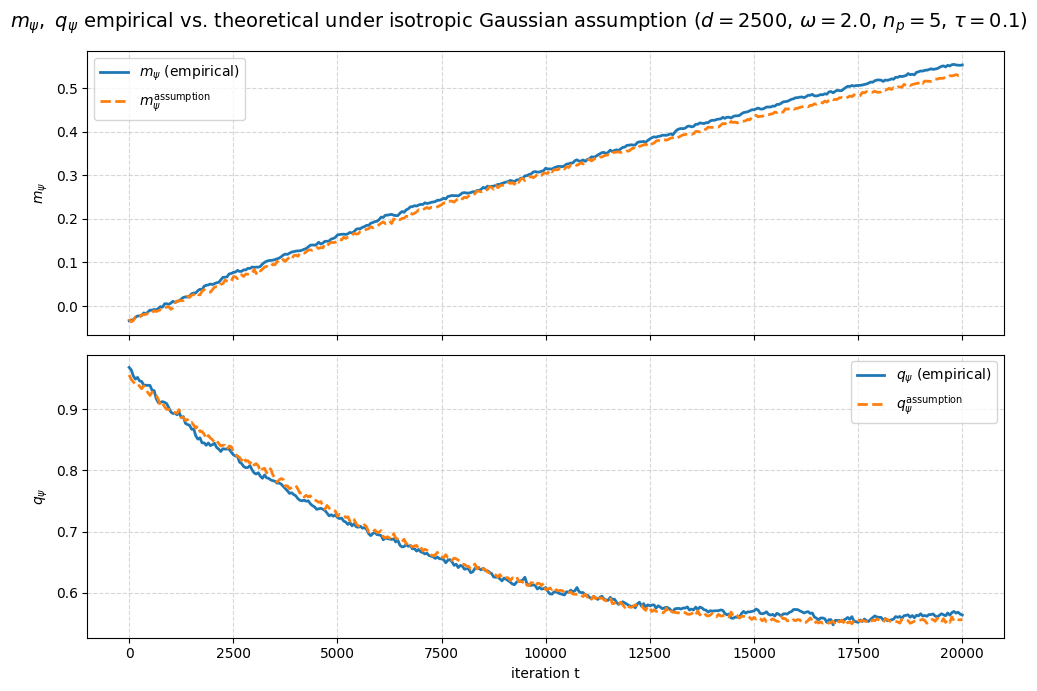

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ----- Parameters -----
d = 2500
tau = 0.1
omega = 2.0
rho = 0.05
n_p = 5
T = 20000
record_every = 50
n_samples = 100_000  # for theoretical expectation

# ----- Quantization -----
def quantize(vec, omega, n_p):
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step

def get_quant_func(omega, n_p):
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    def quant(x):
        clipped = np.clip(x, -omega, omega)
        idx = np.round((clipped + omega) / step)
        return -omega + idx * step
    return quant

quant_func = get_quant_func(omega, n_p)

# ----- Theoretical expressions using isotropic Gaussian assumption -----
def m_psi_theory(m, q, m0, quant_func, n_samples):
    sigma = np.sqrt(q - (m ** 2) / m0 ** 2)
    z = np.random.normal(0, 1, size=n_samples)
    inputs = (m / m0) + sigma * z
    return np.mean(quant_func(inputs))

def q_psi_theory(m, q, m0, quant_func, n_samples):
    sigma = np.sqrt(q - (m ** 2) / m0 ** 2)
    z = np.random.normal(0, 1, size=n_samples)
    inputs = (m / m0) + sigma * z
    return np.mean(quant_func(inputs) ** 2)

# ----- Initialization -----
rng = np.random.default_rng(2028)
w0 = np.ones(d)
w = rng.standard_normal(d)

# ----- Storage -----
steps = []
m_psi_empirical = []
q_psi_empirical = []
m_psi_theoretical = []
q_psi_theoretical = []

# ----- Online learning loop -----
for t in range(T + 1):
    x = rng.standard_normal(d)
    noise = rng.standard_normal() * np.sqrt(rho)
    y = (w0 @ x) / np.sqrt(d) + noise
    wq = quantize(w, omega, n_p)
    y_hat = (wq @ x) / np.sqrt(d)
    grad = -(y - y_hat) * x / np.sqrt(d)
    w -= tau * grad

    if t % record_every == 0:
        m = (w @ w0) / d
        q = (w @ w) / d
        wq = quantize(w, omega, n_p)
        mpsi = (wq @ w0) / d
        qpsi = (wq @ wq) / d
        mpsi_th = m_psi_theory(m, q, m0=1.0, quant_func=quant_func, n_samples=n_samples)
        qpsi_th = q_psi_theory(m, q, m0=1.0, quant_func=quant_func, n_samples=n_samples)

        steps.append(t)
        m_psi_empirical.append(mpsi)
        q_psi_empirical.append(qpsi)
        m_psi_theoretical.append(mpsi_th)
        q_psi_theoretical.append(qpsi_th)

# ----- Plotting -----
fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

axs[0].plot(steps, m_psi_empirical, label=r"$m_\psi$ (empirical)", lw=2)
axs[0].plot(steps, m_psi_theoretical, '--', label=r"$m_\psi^{\mathrm{assumption}}$", lw=2)
axs[0].set_ylabel(r"$m_\psi$")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

axs[1].plot(steps, q_psi_empirical, label=r"$q_\psi$ (empirical)", lw=2)
axs[1].plot(steps, q_psi_theoretical, '--', label=r"$q_\psi^{\mathrm{assumption}}$", lw=2)
axs[1].set_ylabel(r"$q_\psi$")
axs[1].set_xlabel("iteration t")
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

fig.suptitle(
    rf"$m_\psi,\ q_\psi$ empirical vs. theoretical under isotropic Gaussian assumption "
    rf"($d={d}$, $\omega={omega}$, $n_p={n_p}$, $\tau={tau}$)", 
    fontsize=14
)
plt.tight_layout()
plt.show()


Text(0.5, 0.98, 'STE Simulation vs. Theory  ($d=500,\\; \\omega=2.0,\\; n_p=1,\\; \tau=0.1$)')

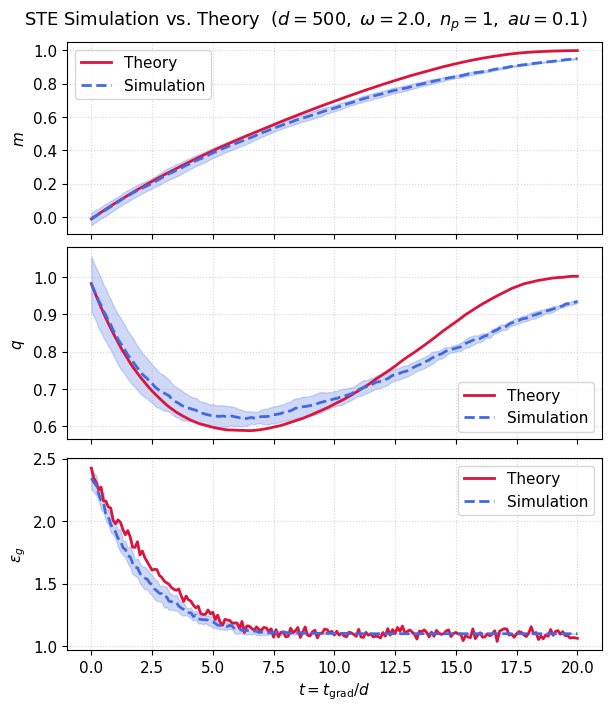

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams.update({'font.size':11})

# Parameters
d,tau,omega,n_p,rho,lam = 500,0.1,2.0,1,0.1,0.0
T_grad,rec,mc_n,n_runs = 10000,50,10000,5
m0, step = 1.0, 2*omega/(n_p+1)

# Fast quantizer
def quantize_array(a):
    idx=np.rint((np.clip(a,-omega,omega)+omega)/step)
    return -omega + idx*step

def psi_scalar(x):
    return -omega + np.rint((np.clip(x,-omega,omega)+omega)/step)*step

# Monte Carlo expectation
def mc_expect(m,q):
    sig2=q-m**2
    z=m+np.sqrt(max(sig2,0))*np.random.randn(mc_n)
    p=psi_scalar(z)
    return p.mean(),(p**2).mean(),(z*p).mean()

def rhs(t,y):
    m,q=y
    e1,e2,e3=mc_expect(m,q)
    dm=-tau*((1+lam)*e1-1)
    dq=-2*tau*((1+lam)*e3-m)+tau**2*(m0-2*e1+e2+rho)
    return dm,dq

# --- Simulation over multiple runs ---
t_grads=np.arange(0,T_grad+1,rec)
t_axis=t_grads/d
M_runs,Q_runs,E_runs=[],[],[]

for seed in range(n_runs):
    rng=np.random.default_rng(seed)
    w=rng.standard_normal(d)
    m_track,q_track,e_track=[],[],[]
    for t_grad in range(T_grad+1):
        if t_grad%rec==0:
            m=(w@np.ones(d))/d; q=(w@w)/d; wq=quantize_array(w)
            e=m0 - 2*(wq@np.ones(d))/d + (wq@wq)/d + rho
            m_track.append(m); q_track.append(q); e_track.append(e)
        x=rng.standard_normal(d)
        y=(np.ones(d)@x)/np.sqrt(d)+rng.normal(scale=np.sqrt(rho))
        wq=quantize_array(w)
        y_hat=(wq@x)/np.sqrt(d)
        w-=tau*-(y-y_hat)*x/np.sqrt(d)
    M_runs.append(m_track); Q_runs.append(q_track); E_runs.append(e_track)

M_runs,Q_runs,E_runs=map(np.array,(M_runs,Q_runs,E_runs))
m_mean,m_std=M_runs.mean(0),M_runs.std(0)
q_mean,q_std=Q_runs.mean(0),Q_runs.std(0)
e_mean,e_std=E_runs.mean(0),E_runs.std(0)

# --- ODE solve ---
sol=solve_ivp(rhs,[0,T_grad/d],[m_mean[0],q_mean[0]],t_eval=t_axis,rtol=1e-4,atol=1e-7)
m_th,q_th=sol.y
e_th=[m0-2*mc_expect(m,q)[0]+mc_expect(m,q)[1]+rho for m,q in zip(m_th,q_th)]

# --- Plot ----------
fig,axes=plt.subplots(3,1,figsize=(6,7),sharex=True,constrained_layout=True)
def add_panel(ax,mean,std,theory,label):
    ax.plot(t_axis,theory,color='crimson',lw=2,label='Theory')
    ax.plot(t_axis,mean,color='royalblue',ls='--',lw=2,label='Simulation')
    ax.fill_between(t_axis,mean-std,mean+std,color='royalblue',alpha=0.25)
    ax.set_ylabel(label)
    ax.grid(True,ls=':',alpha=.5)
    ax.legend()

add_panel(axes[0],m_mean,m_std,m_th,r'$m$')
add_panel(axes[1],q_mean,q_std,q_th,r'$q$')
add_panel(axes[2],e_mean,e_std,e_th,r'$\varepsilon_g$')
axes[2].set_xlabel(r'$t = t_{\mathrm{grad}}/d$')

fig.suptitle(fr'STE Simulation vs. Theory  '
             f'($d={d},\; \omega={omega},\; n_p={n_p},\; \tau={tau}$)',fontsize=13)



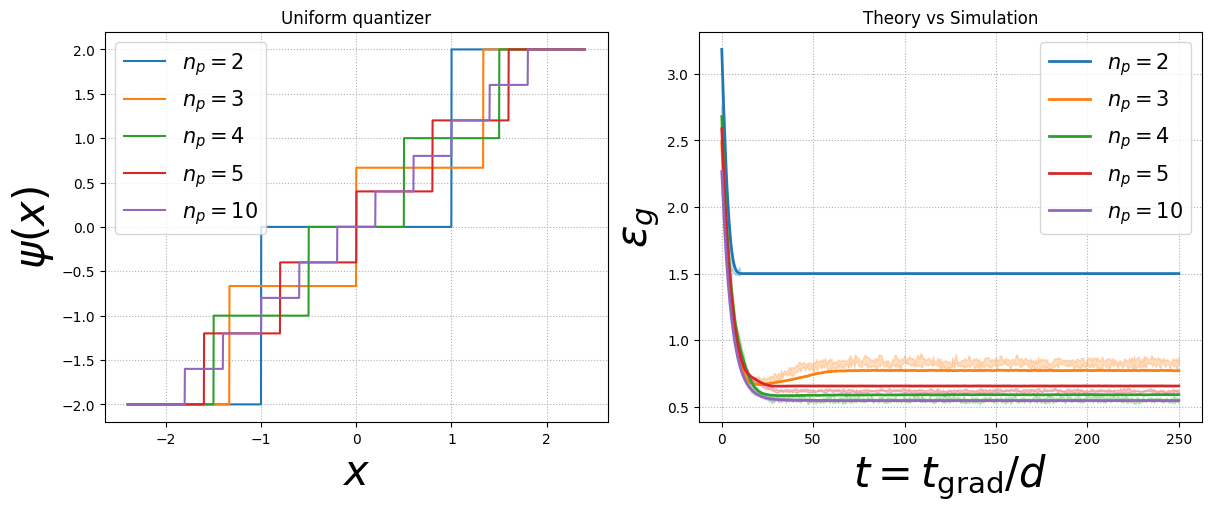

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------------- global hyper‑parameters -------------
d      = 200
tau    = 0.1
omega  = 2.0
rho    = 0.5
lam    = 0.1
T_grad = 50000
rec    = 100
mc_n   = 400000
n_runs = 5
m0     = 1.0
n_p_list = [2, 3, 4, 5, 10]

t_grads = np.arange(0, T_grad + 1, rec)
t_axis  = t_grads / d

# -------- quantizer
def make_step(n_p): return 2*omega/n_p
def psi_scalar(x, step):
    idx = np.rint((np.clip(x,-omega,omega)+omega)/step)
    return -omega + idx*step
quantize_vec = np.vectorize(psi_scalar, excluded={1})

# Monte‑Carlo expectations
def mc_expect(m,q,step):
    var=max(q-m**2,1e-12)
    z=m+np.sqrt(var)*np.random.standard_normal(mc_n)
    psi=psi_scalar(z,step)
    return psi.mean(), (psi**2).mean(), (z*psi).mean()

# ODE RHS
def ode_rhs(t,y,step):
    m,q=y
    e1,e2,e3 = mc_expect(m,q,step)
    dm=-tau*((1+lam)*e1-1)
    dq=-2*tau*((1+lam)*e3-m)+tau**2*(m0-2*e1+e2+rho)
    return dm,dq

def run_one_np(n_p, seed_base=0):
    step=make_step(n_p)
    # simulation runs
    e_runs=[]
    for r in range(n_runs):
        rng=np.random.default_rng(seed_base+r)
        w=rng.standard_normal(d)
        e=[]
        for t_grad in range(T_grad+1):
            if t_grad%rec==0:
                wq=psi_scalar(w,step)
                eps=m0-2*(wq@np.ones(d))/d+(wq@wq)/d+rho
                e.append(eps)
            x=rng.standard_normal(d)
            noise=rng.normal(scale=np.sqrt(rho))
            y=(np.ones(d)@x)/np.sqrt(d)+noise
            wq=psi_scalar(w,step)
            yhat=(wq@x)/np.sqrt(d)
            w-=tau*-(y-yhat)*x/np.sqrt(d)
        e_runs.append(e)
    e_runs=np.array(e_runs)
    sim_mean, sim_std = e_runs.mean(0), e_runs.std(0)

    # ODE
    rng0=np.random.default_rng(seed_base)
    w0=rng0.standard_normal(d)
    m_init, q_init = w0.mean(), (w0@w0)/d
    sol=solve_ivp(ode_rhs,[0,T_grad/d],[m_init,q_init],args=(step,),t_eval=t_axis,rtol=1e-4,atol=1e-7)
    m_th,q_th=sol.y
    e_th=[]
    for m,q in zip(m_th,q_th):
        e1,e2,_=mc_expect(m,q,step)
        e_th.append(m0-2*e1+e2+rho)
    return np.array(e_th), sim_mean, sim_std

# run all
theory, sim_mean, sim_std = {}, {}, {}
for n_p in n_p_list:
    e_th, e_m, e_s = run_one_np(n_p, seed_base=100*n_p)
    theory[n_p]=e_th; sim_mean[n_p]=e_m; sim_std[n_p]=e_s

colors=plt.get_cmap('tab10').colors

# ---------- plots with axes objects ----------
fig, axes = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)

# (a) quantizer shapes
x=np.linspace(-omega*1.2, omega*1.2, 2001)
for idx,n_p in enumerate(n_p_list):
    axes[0].plot(x, psi_scalar(x, make_step(n_p)), color=colors[idx], label=f"$n_p={n_p}$")
axes[0].set_title("Uniform quantizer")
axes[0].set_xlabel(r"$x$", fontsize=30); axes[0].set_ylabel(r"$\psi(x)$", fontsize=30)
axes[0].grid(ls=":"); axes[0].legend(fontsize=15)

# (b) generalization error
for idx,n_p in enumerate(n_p_list):
    c=colors[idx]
    axes[1].plot(t_axis, theory[n_p], color=c, lw=2, label=f"$n_p={n_p}$")
    axes[1].fill_between(t_axis, sim_mean[n_p]-sim_std[n_p],
                        sim_mean[n_p]+sim_std[n_p], color=c, alpha=0.25)
axes[1].set_xlabel(r"$t=t_{\mathrm{grad}}/d$", fontsize=30)
axes[1].set_ylabel(r"$\varepsilon_g$", fontsize=30)
axes[1].set_title("Theory vs Simulation")
axes[1].grid(ls=":")
axes[1].legend(fontsize=15)

plt.show()


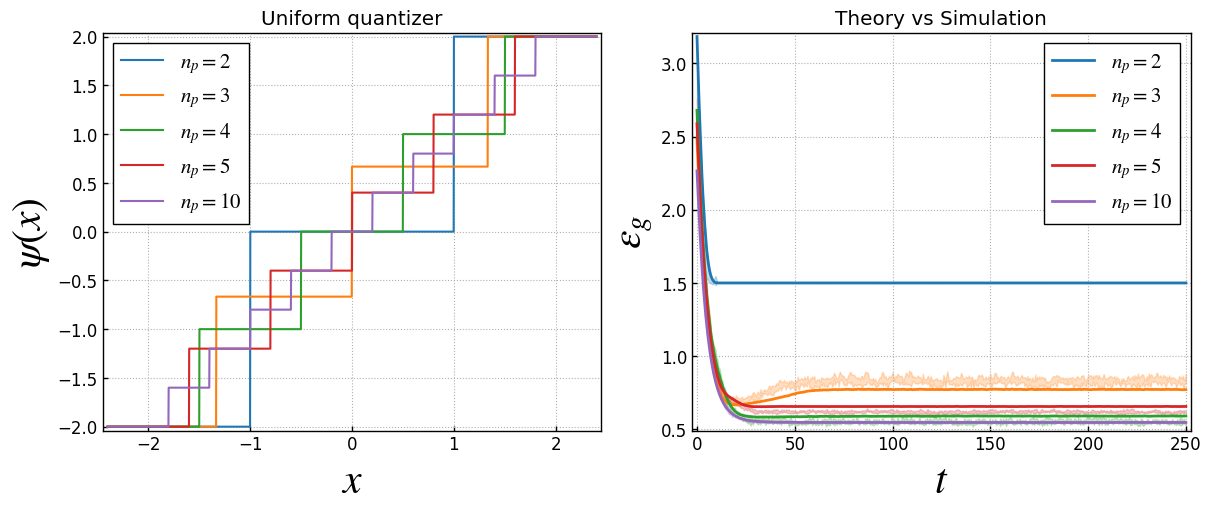

In [6]:

# ---------- plots with axes objects ----------
fig, axes = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)

# (a) quantizer shapes
x=np.linspace(-omega*1.2, omega*1.2, 2001)
for idx,n_p in enumerate(n_p_list):
    axes[0].plot(x, psi_scalar(x, make_step(n_p)), color=colors[idx], label=f"$n_p={n_p}$")
axes[0].set_title("Uniform quantizer")
axes[0].set_xlabel(r"$x$", fontsize=30); axes[0].set_ylabel(r"$\psi(x)$", fontsize=30)
axes[0].grid(ls=":"); axes[0].legend(fontsize=15)

# (b) generalization error
for idx,n_p in enumerate(n_p_list):
    c=colors[idx]
    axes[1].plot(t_axis, theory[n_p], color=c, lw=2, label=f"$n_p={n_p}$")
    axes[1].fill_between(t_axis, sim_mean[n_p]-sim_std[n_p],
                        sim_mean[n_p]+sim_std[n_p], color=c, alpha=0.25)
axes[1].set_xlabel(r"$t$", fontsize=30)
axes[1].set_ylabel(r"$\varepsilon_g$", fontsize=30)
axes[1].set_title("Theory vs Simulation")
axes[1].grid(ls=":")
axes[1].legend(fontsize=15)

plt.show()


/var/folders/hg/bzv_pls92yqct01y805bdhfh0000gn/T/ipykernel_63552/654460455.py:38: RuntimeWarning: overflow encountered in exp
  s = np.exp(u)


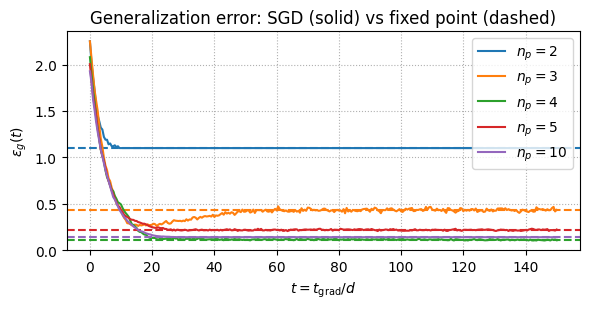

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm

# ------------------- hyper‑parameters -------------------
d, tau, omega = 200, 0.1, 2.0
rho, lam      = 0.1, 0.0
T_grad, rec   = 30000, 100        # simulation length
n_runs        = 4                 # SGD repetitions
n_p_list      = [2, 3, 4, 5, 10]

# time axis for plotting
t_grads = np.arange(0, T_grad + 1, rec)
t_axis  = t_grads / d

# ------------------- quantizer helpers ------------------
def make_step(n_p): return 2 * omega / n_p        # mid‑tread
def psi_scalar(x, step):
    idx = np.rint((np.clip(x, -omega, omega) + omega) / step)
    return -omega + idx * step

# ------------------- MC pool for expectations ----------
MC_N  = 120_000
xi_mc = np.random.default_rng(0).standard_normal(MC_N)

def mc_expect(m, q, step):
    var = max(q - m * m, 1e-12)
    z = m + np.sqrt(var) * xi_mc
    psi = psi_scalar(z, step)
    return psi.mean(), (psi**2).mean(), (z * psi).mean()

# ------------------- fixed‑point solver ----------------
def fixed_point(n_p):
    step = make_step(n_p)
    def F(vec):
        m, u = vec                 # u = log(s),  s>0
        s = np.exp(u)
        q = m * m + s * s
        Epsi, Epsi2, Ezpsi = mc_expect(m, q, step)
        f1 = (1 + lam) * Epsi - 1
        f2 = -2 * tau * ((1 + lam) * Ezpsi - m) + tau**2 * (1 - 2 * Epsi + Epsi2 + rho)
        return [f1, f2]
    # multi‑start search for robust convergence
    for m0 in np.linspace(0.2, 1.5, 6):
        for s0 in np.linspace(0.3, 1.0, 4):
            sol = root(F, [m0, np.log(s0)], method='hybr', tol=1e-8)
            if sol.success and np.linalg.norm(sol.fun) < 1e-6:
                m_star, u_star = sol.x
                s_star = np.exp(u_star)
                q_star = m_star * m_star + s_star * s_star
                Epsi, Epsi2, _ = mc_expect(m_star, q_star, step)
                eps_star = 1 - 2 * Epsi + Epsi2 + rho
                return m_star, q_star, eps_star, step
    raise RuntimeError(f"No root for n_p={n_p}")

fixed_pts = {n: fixed_point(n) for n in n_p_list}

# ------------------- simulation dynamics ----------------
traj_m, traj_q, traj_e = {}, {}, {}
for n_p in n_p_list:
    step = fixed_pts[n_p][3]
    m_runs, q_runs, e_runs = [], [], []
    for run in range(n_runs):
        rng = np.random.default_rng(1234 + n_p * 10 + run)
        w   = rng.standard_normal(d)
        m_hist, q_hist, e_hist = [], [], []
        for t in range(T_grad + 1):
            if t % rec == 0:
                wq = psi_scalar(w, step)
                m_hist.append((wq @ np.ones(d)) / d)
                q_hist.append((wq @ wq) / d)
                e_hist.append(1 - 2 * m_hist[-1] + q_hist[-1] + rho)
            x = rng.standard_normal(d)
            noise = rng.normal(scale=np.sqrt(rho))
            y = (np.ones(d) @ x) / np.sqrt(d) + noise
            wq = psi_scalar(w, step)
            y_hat = (wq @ x) / np.sqrt(d)
            w -= tau * (-(y - y_hat) * x / np.sqrt(d))
        m_runs.append(m_hist)
        q_runs.append(q_hist)
        e_runs.append(e_hist)
    traj_m[n_p] = np.mean(m_runs, axis=0)
    traj_q[n_p] = np.mean(q_runs, axis=0)
    traj_e[n_p] = np.mean(e_runs, axis=0)

# plot only generalization error with fixed-point dashed
import matplotlib.pyplot as plt
colors = plt.get_cmap('tab10').colors
plt.figure(figsize=(6,3.2))
for idx,n_p in enumerate(n_p_list):
    c=colors[idx]
    eps_fp = fixed_pts[n_p][2]
    plt.plot(t_axis, traj_e[n_p], color=c, label=f"$n_p={n_p}$")
    plt.axhline(eps_fp, color=c, ls='--')
plt.xlabel(r"$t=t_{\mathrm{grad}}/d$")
plt.ylabel(r"$\varepsilon_g(t)$")
plt.title("Generalization error: SGD (solid) vs fixed point (dashed)")
plt.grid(ls=':')
plt.legend()
plt.tight_layout()
plt.show()

